In [3]:
!pip install pysindy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 113 kB 16.8 MB/s eta 0:00:01
     |████████████████████████████████| 23.3 MB 25.3 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=76aeae61447c0283d01ed9cf72dedc4fb0feb3bf833cac24f893c3cc5a29251e
  Stored in directory: /tmp/pip-ephem-wheel-cache-b75ztanp/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [4]:
#commom imports
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import pandas as pd
import os
import tqdm
from datetime import datetime
from matplotlib import pyplot as plt
import math
import pickle
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from torch.autograd import grad

%matplotlib inline

#deepmod imports, folder is local
sys.path.insert(0, './DeePyMoD/src/')
# DeepMoD functions
from deepymod import DeepMoD
from deepymod.model.func_approx import NN
from deepymod.data import Dataset, get_train_test_loader
from deepymod.model.library import Library1D
from deepymod import Library
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from deepymod.model.func_approx import Siren
from deepymod.utils.logger import Logger


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

#device will be cpu for now, changes are required to make it cuda compatible
device = "cpu"
print("Device is:",device)

#auxiliar functions



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device is: cpu


In [5]:
from typing import *

class SinCosLayer(torch.nn.Module):
    def __init__(
        self,
        p_list: List[float]
    ) -> None:
        """Sin/Cos activation function layer with different period.
        Args:

        """
        super().__init__()
        self.p_list = p_list

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Forward pass through the layer.
        Args:
            input (torch.Tensor): Input tensor of shape (n_samples, n_inputs).
        Returns:
            torch.Tensor: Prediction of shape (n_samples, n_outputs)
        """
        n_in = input.shape[1]
        n_p = len(self.p_list)
        
        sincos_list = []
        for i in range(n_p):
            omega = 2.0*np.pi/self.p_list[i]
            
            sincos_list.append(torch.sin(omega*input[:, 0:1]))
            sincos_list.append(torch.cos(omega*input[:, 0:1]))
            
        output = torch.cat([input] + sincos_list, dim=1)
        
        return output       
        

class SCNN(torch.nn.Module):
    def __init__(self, n_in: int, n_hidden: List[int], n_out: int, p_list: List[float]) -> None:
        """Constructs a feed-forward neural network with tanh activation.
        Args:
            n_in (int): Number of input features.
            n_hidden (List[int]): Number of neurons in each layer.
            n_out (int): Number of output features.
            p_list (List[float]): list of sin/cos period
        """
        super().__init__()
        self.p_list = p_list
        self.network = self.build_network(n_in, n_hidden, n_out, p_list)

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through the network. Returns prediction and the differentiable input
        so we can construct the library.
        Args:
            input (torch.Tensor): Input tensor of size (n_samples, n_inputs).
        Returns:
            (torch.Tensor, torch.Tensor): prediction of size (n_samples, n_outputs) and coordinates of size (n_samples, n_inputs).
        """
        coordinates = input.clone().detach().requires_grad_(True)
        return self.network(coordinates), coordinates

    def build_network(self, n_in: int, n_hidden: List[int], n_out: int, p_list: [float]) -> torch.nn.Sequential:
        """Constructs a feed-forward neural network.
        Args:
            n_in (int): Number of input features.
            n_hidden (list[int]): Number of neurons in each layer.
            n_out (int): Number of output features.
            p_list (List[float]): list of sin/cos period
        Returns:
            torch.Sequential: Pytorch module
        """

        network = [SinCosLayer(p_list)]
        
        n_sc_out = n_in + len(p_list) * 2
        
        architecture = [n_sc_out] + n_hidden + [n_out]
        for layer_i, layer_j in zip(architecture, architecture[1:]):
            network.append(torch.nn.Linear(layer_i, layer_j))
            network.append(torch.nn.Tanh())
        network.pop()  # get rid of last activation function
        return torch.nn.Sequential(*network)

# 1D Implementation - Tanh neural nets, SIREN, Custom Sinusoidal, Custom 1D library and Error Visualization

In [6]:
df = pd.read_pickle("./dataframe.pk.zip")
df.head()

,Time1,Time2,Para,Alt,Lon,Lat,Val,Houridx
0,2008-01-01 00:00:00,2008-01-01 00:00:00,PRES,surface,-20,23,102132.0,333095.0
1,2008-01-01 00:00:00,2008-01-01 00:00:00,PRES,surface,-19,23,102022.0,333095.0
2,2008-01-01 00:00:00,2008-01-01 00:00:00,PRES,surface,-18,23,102090.0,333095.0
3,2008-01-01 00:00:00,2008-01-01 00:00:00,PRES,surface,-17,23,102077.0,333095.0
4,2008-01-01 00:00:00,2008-01-01 00:00:00,PRES,surface,-16,23,101260.0,333095.0


For future work, what can be done is investigating correlation between all these variables and temperature and then use the ones that are highly correlated as inputs to the model to estimate temperature in the future.

## Data preprocessing - Only temperature in Celsius, only on surface, only on (28,-15); Time in days since 01/01/2008

In [16]:
#getting only temperature at surface level and at point(28,-15), that's why it's 1D
case1_df = df[(df.Para == "TMP") & (df.Alt == "surface") & (df.Lat == 28) & (df.Lon == -15)]

#converting temperature to Celsiu and then normalizing
temporary_df = case1_df.copy()
temporary_df.Val -= 273.15



In [17]:
print(0.07380938336854444*temporary_df["Val"].std())
print(np.sqrt(0.01*temporary_df["Val"].std()**2))

0.1308350238045955
0.17726069211459344


In [18]:
#temporary_df["Val"] = (temporary_df["Val"] - temporary_df["Val"].mean())/ temporary_df["Val"].std()
temps = temporary_df["Val"].to_numpy()
errors = []
rmse_errors = []
for i in range(temps.shape[0]-1):
    error = np.abs((temps[i+1]-temps[i]))
    errors.append(error)
    #rmse_errors.append(error**2)

print(np.mean(errors))
#print(np.sqrt(np.mean(rmse_errors)))

0.13083502380459552


In [63]:
#scaled to [0,1]
temporary_df["Val"] = (temporary_df["Val"] - temporary_df["Val"].mean())/ temporary_df["Val"].std()

#scaled to [-1,1]
#temporary_df["Val"]         = 1 + (((temporary_df["Val"]-temporary_df["Val"].min())*(-1-1))/(temporary_df["Val"].max()-temporary_df["Val"].min()))


#converting date to days, starting at 0 at the 1st inicial day
inicial_time = temporary_df["Houridx"].iloc[0]
temporary_df.Houridx -= inicial_time

final_df = temporary_df.copy()
final_df["Houridx"] = final_df["Houridx"]/24.0

temperature_array = final_df["Val"].to_numpy()
time_array        = final_df["Houridx"].to_numpy()




In [53]:
print(final_df["Houridx"].shape)
print(13.3*365)

(4832,)
4854.5


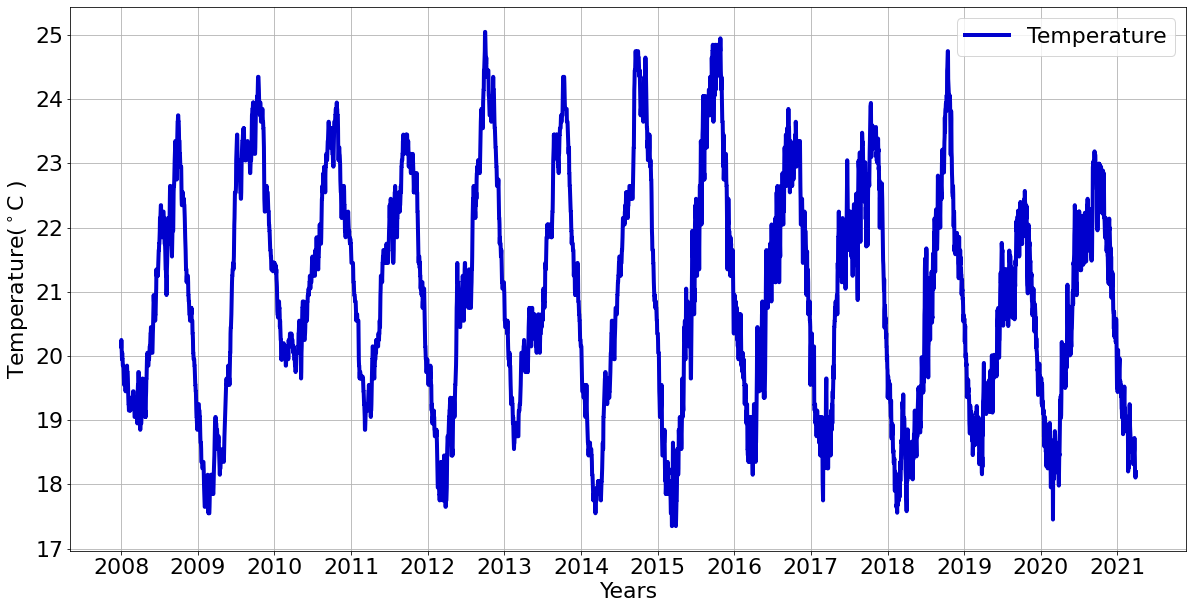

In [57]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.grid()
plt.xlabel("Years")
plt.xticks(np.arange(2008,2022,1))
plt.ylabel("Temperature($^\circ$C )")
plt.plot(final_df["Houridx"]/365+2008,final_df["Val"],linewidth=4,label="Temperature",color="mediumblue")
plt.legend()
plt.savefig("temperature_trend.png",format="png",bbox_inches="tight")
plt.show()


### Fourier Transform to get the main frequencies present on the signal

In [18]:
from scipy.fft import rfft, rfftfreq

total_time_points = time_array.shape[0]
yf = rfft(temperature_array)
xf = rfftfreq(total_time_points)

#table = hv.Table((xf[:50].reshape(1,-1)*365,np.abs(yf[:50].reshape(1,-1))), 'x', 'y')

#curve = hv.Curve(table).opts(frame_width=1000,xlabel="Time in years")

#getting the frequencies with higher coeficients

sorted_yf = sorted(np.abs(yf),reverse=True)

print()
print()
frequencies = []

for i,coef in enumerate(np.abs(yf)):
    if coef in sorted_yf[:10]:
        frequencies.append((xf[i]))

plt.figure(figsize=(20,10))
print("The 10 frequencies with the biggest coefs are:")    
print(np.array(frequencies)*365)



The 10 frequencies with the biggest coefs are:
[0.07553808 0.15107616 0.67984272 0.75538079 0.83091887 0.90645695
 0.98199503 1.05753311 1.96399007 2.03952815]


<Figure size 1440x720 with 0 Axes>

So we see in terms of months that we some sort of monthly peridiocity.

This information will be useful when building the Libary of functions that will than fit the problem.

## Dataset function creation

In [20]:
#creating the dataset loader

t_train = torch.tensor(time_array,dtype=torch.float32).view(-1,1)
print(t_train.shape)
#test to see if inputing the coords helps solving the error
#we have only one point in space so I will just fill x_train with ones, is not important
x_train = torch.ones_like(t_train)

Y_train = torch.tensor(temperature_array,dtype=torch.float32).view(-1,1)
X_train = torch.cat((t_train,x_train),dim=1)

n_train = int(X_train.shape[0]*1)
auxiliar = X_train[:n_train,:], Y_train[:n_train,:]



torch.Size([4832, 1])


In [21]:
dataset = Dataset(auxiliar,device=device)

train_dataloader, test_dataloader = get_train_test_loader(
    dataset, train_test_split=0.8
)
    


Dataset is using device:  cpu


## Plotting Auxiliary function --> Later to be put on a different script

In [70]:
def plotting_predictions(number_of_years:int,filename,test_fraction:int=0.8,time_array=time_array,temperature_array=temperature_array,show_error=False):
    
    x_array     = np.arange(0,365*number_of_years,1)
    pred_array  = np.zeros(x_array.shape)
    
    #error should only be used in test set
    test_index = int(test_fraction*len(time_array))
    error_array = np.zeros(time_array[test_index:].shape)
    rmse = []
    mae  = []
    for i,t in enumerate(x_array):
        in_data            = [[t,1]]
        prediction         = model.func_approx(torch.Tensor(in_data))[0].item()
        pred_array[i]      = prediction
        if (i >= test_index) and i < (len(time_array)-1) :
            diff = (temperature_array[i] - prediction)
            error_array[i-test_index] = diff/temperature_array[i]*100
        
            rmse.append(diff**2)
            mae.append(np.abs(diff))

    
    #rmse = np.sqrt((rmse)/len(error_array))
    
    #np.savetxt(filename,(x_array,pred_array),delimiter=",")
    
        
       
    #prediction plot
    fig = plt.figure(figsize=(20,9)) 
    plt.scatter(x_array/365+2008,pred_array,c="r",label="Model")
    plt.plot(time_array[:int(0.8*len(time_array))]/365.0+2008, temperature_array[:int(0.8*len(time_array))], '*b', label='Train Data')
    plt.plot(time_array[int(0.8*len(time_array)):]/365.0+2008,temperature_array[int(0.8*len(time_array)):],"*g",label ="Test Data")
    plt.legend()
    #plt.title(f"{filename}")
    plt.grid(True)
    plt.xlabel('Year')
    plt.ylabel('Normalized Temperature')
    plt.savefig("temp1D.png",format="png",bbox_inches="tight")
    plt.show()
    
    
    x_array       = x_array/365+2008
    x_train_array = time_array[:int(0.8*len(time_array))]/365.0+2008
    x_test_array   = time_array[int(0.8*len(time_array)):]/365.0+2008
    y_test       = temperature_array[int(0.8*len(time_array)):]
    fig = plt.figure(figsize=(20,9)) 
    plt.scatter(x_array[-x_test_array.shape[0]*2-55:-x_test_array.shape[0]-55],pred_array[-x_test_array.shape[0]*2-55:-x_test_array.shape[0]-55],c="r",label="Model")
    plt.plot(x_test_array,y_test,"*g",label ="Test Data")
    plt.legend()
    #plt.title(f"{filename}")
    plt.grid(True)
    plt.xlabel('Year')
    plt.ylabel('Normalized Temperature')
    plt.savefig("temp1D_zoom.png",format="png",bbox_inches="tight")
    plt.show()
    
    
    

    
    if show_error:
        #error plot
        plt.figure(figsize=(20,9))
        plt.scatter(time_array[test_index:]/365+2008,error_array,c="navy",label="Relative error")
        plt.legend()
        plt.grid(True)
        plt.xlabel('Year')
        plt.ylabel('Relative Error(%)')
        plt.savefig("temp1D_error.png",format="png",bbox_inches="tight")
        plt.show()

        #zoomed error plot, ignore outliers
        plt.figure(figsize=(20,9))
        plt.scatter(time_array[test_index:]/365+2008,np.abs(error_array),c="navy",label="Relative error")
        plt.ylim(0,1000)
        plt.legend()
        plt.grid(True)
        plt.xlabel('Year')
        plt.ylabel('Relative Error(%) on the test set')
        plt.savefig("temp1D_error.png",format="png",bbox_inches="tight")
        plt.show()
        
        #zoomed error plot, ignore outliers
        plt.figure(figsize=(20,9))
        plt.scatter(time_array[test_index:]/365+2008,np.abs(error_array),c="darkblue",label="Relative error")
        plt.ylim(0,200)
        plt.legend()
        plt.grid(True)
        plt.xlabel('Year')
        plt.ylabel('Relative Error(%) on the test set')
        plt.savefig("temp1D_error_zoom.png",format="png",bbox_inches="tight")
        plt.show()
    
    #error printing
    print("RMSE:", np.sqrt(np.mean(rmse)))
    print("MAE:",np.mean(mae))
    


### Implementation using just DeepMod source code

In [49]:
network = Siren(2, [30, 30,30,30], 1,3,3)
library = Library1D(poly_order=2, diff_order=3)
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=1000, delta=1e-6)
constraint = LeastSquares()
model = DeepMoD(network, library, estimator, constraint).to(device)

In [50]:
optimizer = torch.optim.AdamW(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3)

IM here
     0  MSE: 1.09e+00   MSE_TEST: 1.07e+00   Reg: 1.11e-01  L1: 4.51e-01 
   100  MSE: 9.89e-01   MSE_TEST: 9.87e-01   Reg: 9.86e-03  L1: 3.54e-01 
   200  MSE: 6.14e-01   MSE_TEST: 6.16e-01   Reg: 9.84e-02  L1: 1.03e+00 
   300  MSE: 4.47e-01   MSE_TEST: 4.44e-01   Reg: 1.06e-01  L1: 7.88e-01 
   400  MSE: 2.70e-01   MSE_TEST: 2.72e-01   Reg: 2.01e-01  L1: 5.83e-01 
   500  MSE: 1.62e-01   MSE_TEST: 1.62e-01   Reg: 2.33e-01  L1: 3.51e-01 
   600  MSE: 1.10e-01   MSE_TEST: 1.09e-01   Reg: 2.27e-01  L1: 3.72e-01 
   700  MSE: 8.17e-02   MSE_TEST: 8.08e-02   Reg: 2.21e-01  L1: 3.95e-01 
   800  MSE: 6.25e-02   MSE_TEST: 6.27e-02   Reg: 2.32e-01  L1: 3.45e-01 
   900  MSE: 5.06e-02   MSE_TEST: 5.03e-02   Reg: 2.65e-01  L1: 3.38e-01 
  1000  MSE: 4.14e-02   MSE_TEST: 4.12e-02   Reg: 3.03e-01  L1: 3.35e-01 
  1100  MSE: 3.46e-02   MSE_TEST: 3.53e-02   Reg: 3.48e-01  L1: 3.64e-01 
  1200  MSE: 2.92e-02   MSE_TEST: 2.98e-02   Reg: 3.83e-01  L1: 3.54e-01 
  1300  MSE: 2.62e-02   MSE_TE

/opt/conda/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


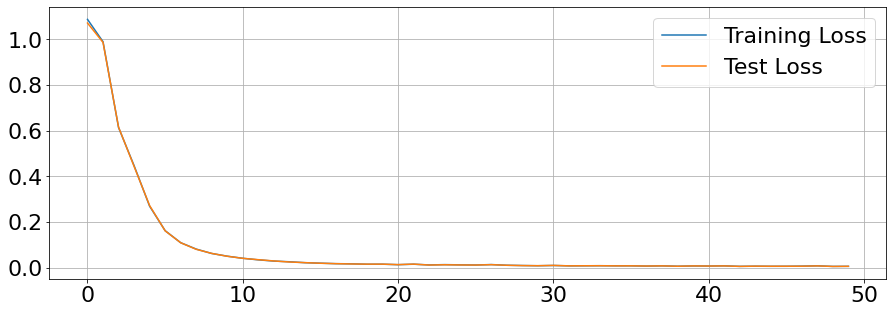

Algorithm converged. Writing model to disk.


In [51]:
train(
    model,
    train_dataloader,
    train_dataloader,
    optimizer,
    sparsity_scheduler,
    exp_ID=None,
    log_dir = None,
    write_iterations=100,
    max_iterations=5000,
    delta=1e-4,
    patience=50,
    reg_coef = 0
)

In [47]:
print(model.sparsity_masks)
print()

#just printing as rows to facilite visualization
coefs = np.reshape(model.estimator_coeffs(),(1,-1))
print(coefs)

[tensor([ True, False, False, False, False, False, False, False,  True, False,
        False,  True,  True, False,  True, False,  True, False,  True])]

[[-0.10607097  0.          0.          0.          0.          0.
   0.          0.          0.20504114  0.          0.          0.46238437
   0.5180636   0.         -0.17384681  0.          0.21012895  0.
  -0.23658858]]


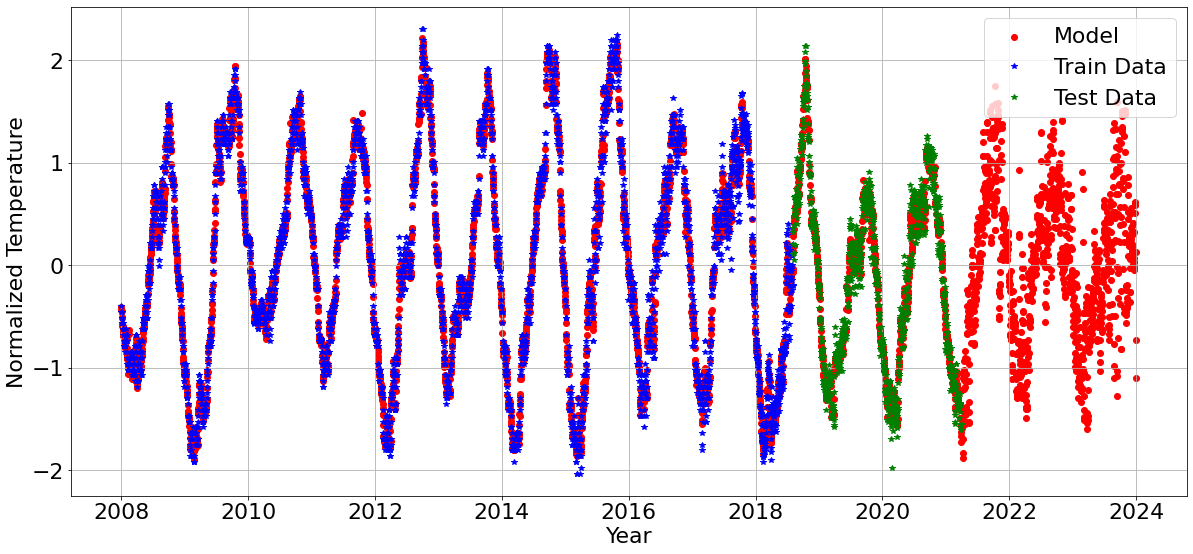

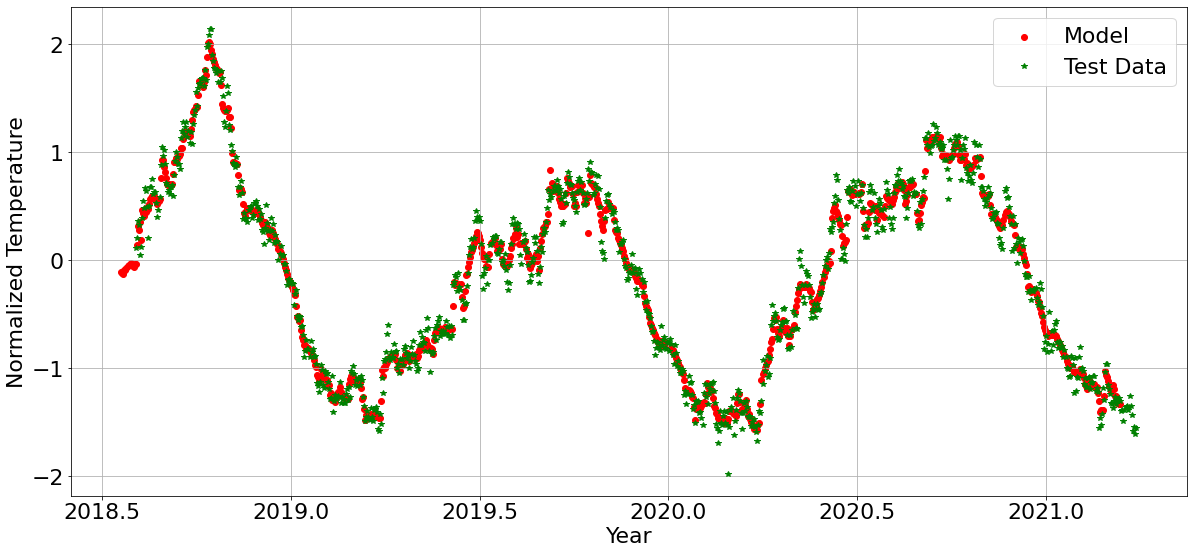

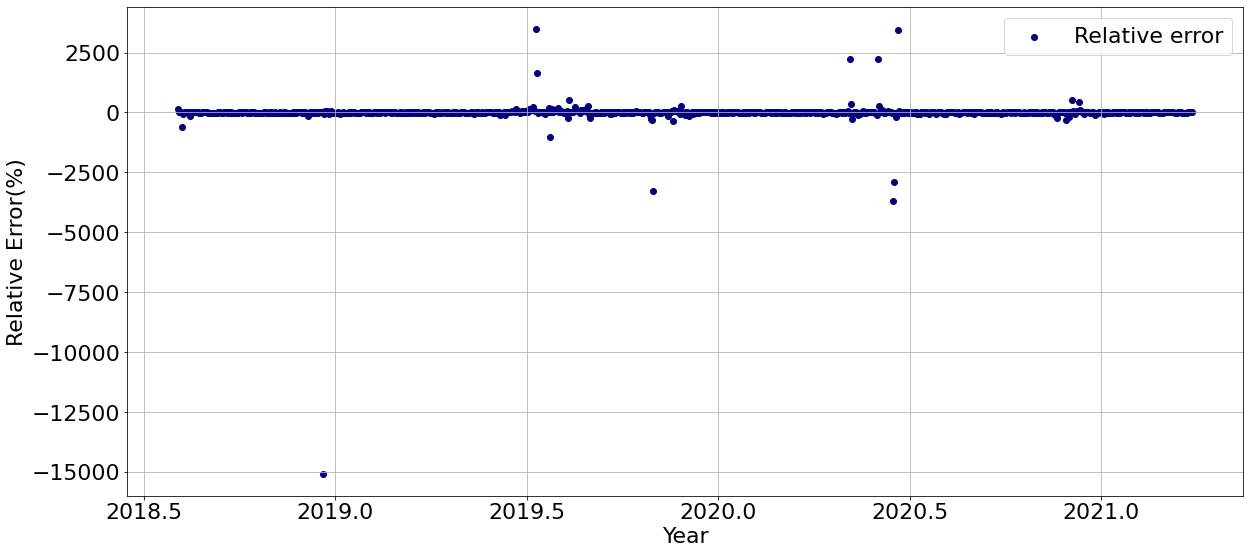

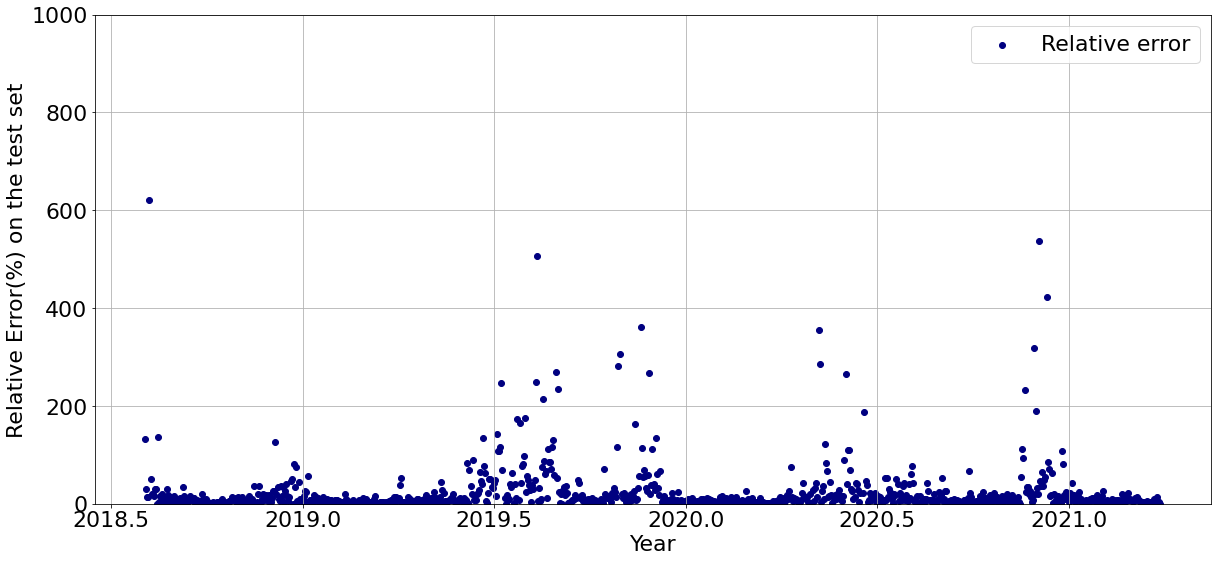

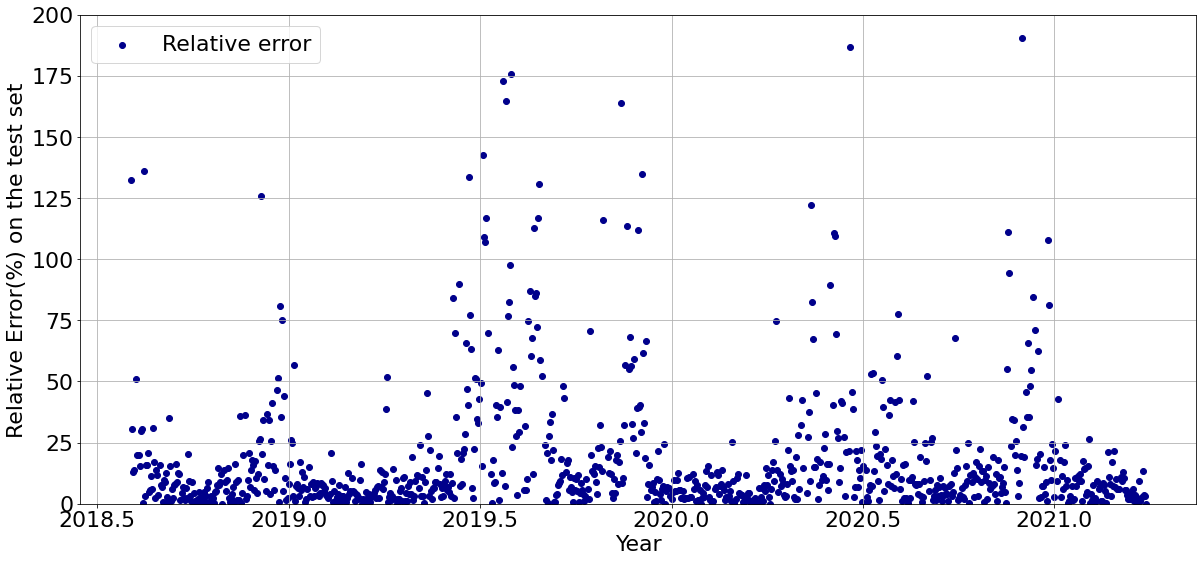

RMSE: 0.10366113387153594
MAE: 0.07805430054165623


In [71]:
plotting_predictions(number_of_years=16,filename="test",show_error=True);

### Implementation a custom Library with sinusoidal components

In [23]:
from typing import *
class CustomLibrary(Library):

    def __init__(self, poly_order: int, diff_order: int, frequencies_list: list,full_library=False):
        super().__init__()
        self.poly_order     = poly_order
        self.diff_order     = diff_order
        self.frequencies    = frequencies_list
        self.full_library = full_library

    def library(self, input):
        prediction, data = input
        lib = Library1D(poly_order=self.poly_order, diff_order=self.diff_order)

        time_deriv_list, default_theta = lib.library(input=input)
        
        #default_theta_tensor = torch.stack(default_theta)
        #print(time_deriv_list.dtype)

        time_array = data[:, 0:1]
        c = torch.ones(time_array.shape[0],1)
        for i,frequency in enumerate(self.frequencies):
            omega       = 2*np.pi*frequency # when "period" is actually the frequency
            #sines     = torch.sin(time_array*omega).reshape(-1,1)
            #cossines   = torch.cos(time_array*omega).reshape(-1,1)
            d_sines     = omega*torch.sin(time_array*omega).reshape(-1,1)
            d_cossines  = -omega*torch.cos(time_array*omega).reshape(-1,1)
            #sines2      = -omega*omega*torch.sin(time_array*omega).reshape(-1,1)
            #cossines2   = -omega*omega*torch.cos(time_array*omega).reshape(-1,1)
            #print(sines)
            b        = torch.hstack((c,d_cossines,d_sines))
            c        = torch.clone(b)
            
        if self.full_library:
            sinu_theta = c[:,1:]#default theta already has a 1 column
            theta = torch.cat([default_theta + sinu_theta],dim=1)
        else:
            theta = c
        
        return time_deriv_list, [theta]
    

class Library_nonlinear(Library):
    """[summary]

    Args:
        Library ([type]): [description]
    """
    def __init__(self, period_list) -> None:
        super().__init__()
        self.period_list = period_list
        
        self.cal_count = 0

    #def library(self, input: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[TensorList, TensorList]:
    def library(self, input):
        prediction, data = input
        samples = prediction.shape[0]
        
        n_order = int((data.shape[1] - 1)/2.0)
                
        # Construct the theta matrix
        C = torch.ones_like(prediction[:,0]).view(samples, -1)
        
        # ipdb.set_trace()
        
        time_array = data[:, 0:1]
        arg_state_list = []
        for i in range(len(self.period_list)):
            omega = 2.0*np.pi/self.period_list[i]
            arg_state_list.append(torch.sin(time_array*omega)*omega)
            arg_state_list.append(torch.cos(time_array*omega)*omega) 
        
        #arg_state_list = []
        #for i in range(n_order):
        #    arg_state_list.append(data[:, 2*i+2].view(samples, -1))
        #    arg_state_list.append(data[:, 2*i+1].view(samples, -1)*-1.0)
        
        theta = torch.cat([C] + arg_state_list, dim=1)
    
        # Construct a list of time_derivatives 
        time_deriv_list = []
        for output in torch.arange(prediction.shape[1]):
            dy = grad(prediction[:,output], data, grad_outputs=torch.ones_like(prediction[:,output]), create_graph=True, allow_unused=True)[0]
            time_deriv = dy[:, 0:1]
            time_deriv_list.append(time_deriv)       
        
        return time_deriv_list, [theta[:, 1:]]

In [24]:
ftt_frequencies_list = np.array(frequencies[1:])

network            = Siren(2, [60,60,60,60,60], 1,first_omega_0=3,hidden_omega_0=3)
library            = CustomLibrary(poly_order=4, diff_order=1,frequencies_list=ftt_frequencies_list)
estimator          = PDEFIND()
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-6)
constraint         = LeastSquares()
model              = DeepMoD(network, library, estimator, constraint).to(device)
optimizer          = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3)

     0  MSE: 1.07e+00   MSE_TEST: 1.04e+00   Reg: 1.20e-01  L1: 1.86e-01 
  1000  MSE: 1.85e-01   MSE_TEST: 1.73e-01   Reg: 5.01e-03  L1: 5.15e-01 
  2000  MSE: 9.15e-02   MSE_TEST: 9.68e-02   Reg: 2.47e-03  L1: 7.73e-01 
  3000  MSE: 7.85e-03   MSE_TEST: 1.39e-02   Reg: 3.10e-04  L1: 1.86e+00 
  4000  MSE: 6.80e-03   MSE_TEST: 1.34e-02   Reg: 2.02e-04  L1: 2.02e+00 
  5000  MSE: 6.34e-03   MSE_TEST: 1.38e-02   Reg: 1.75e-04  L1: 2.04e+00 


/opt/conda/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


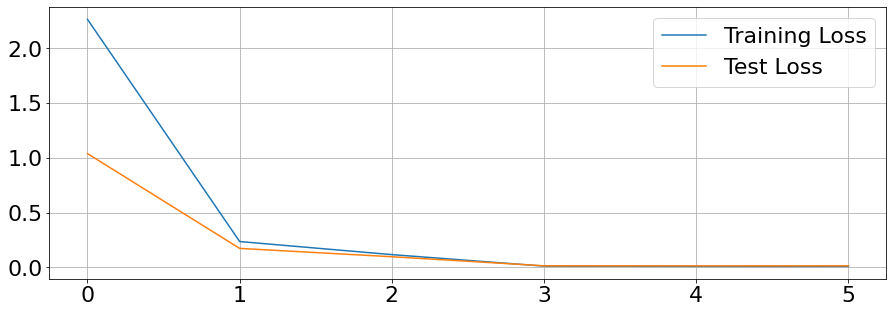

Algorithm converged. Writing model to disk.


In [25]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    exp_ID="Test",
    write_iterations=1000,
    max_iterations=5001,
    delta=1e-4,
    patience=8,
    reg_coef = 10
)

In [60]:
print(model.sparsity_masks)
print()

#just printing as rows to facilitate visualization
coefs = np.reshape(model.estimator_coeffs(),(1,-1))
print(coefs)

[tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True])]

[[-0.00928701 -0.00465715  0.00543784  0.          0.00482804  0.00412479
   0.01833697  0.01071698  0.01372626  0.01053016  0.02499584  0.030266
   0.04296798  0.         -0.00795825  0.02185752 -0.01547788  0.0059198
  -0.00455028]]


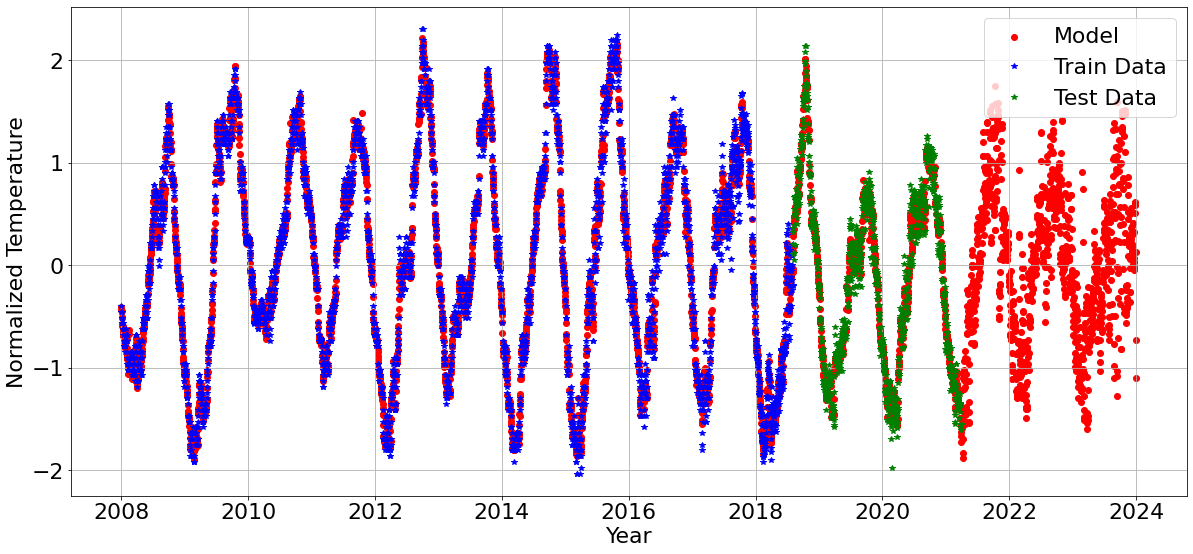

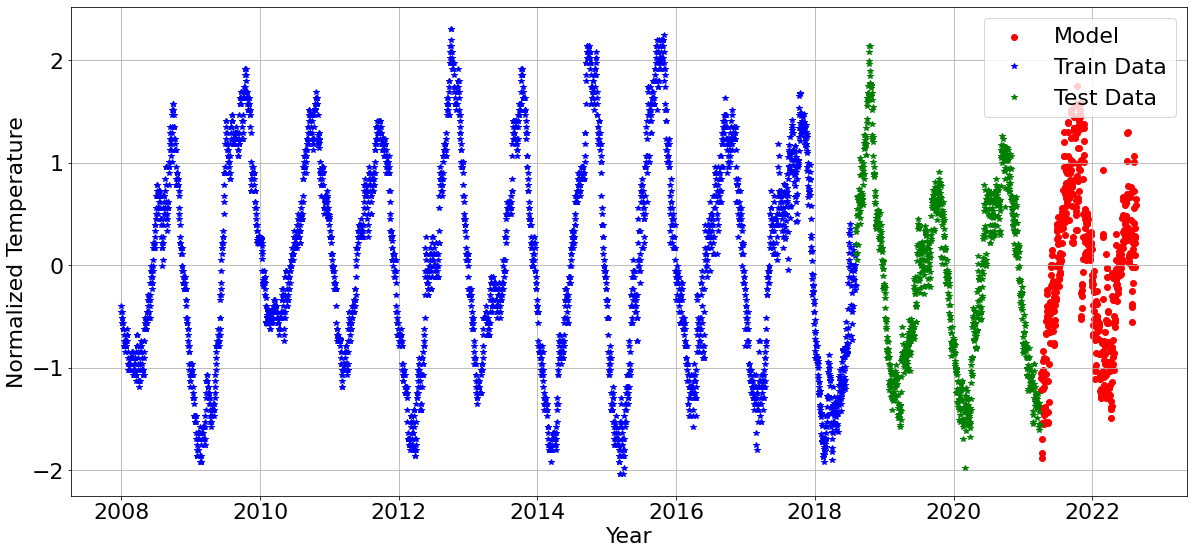

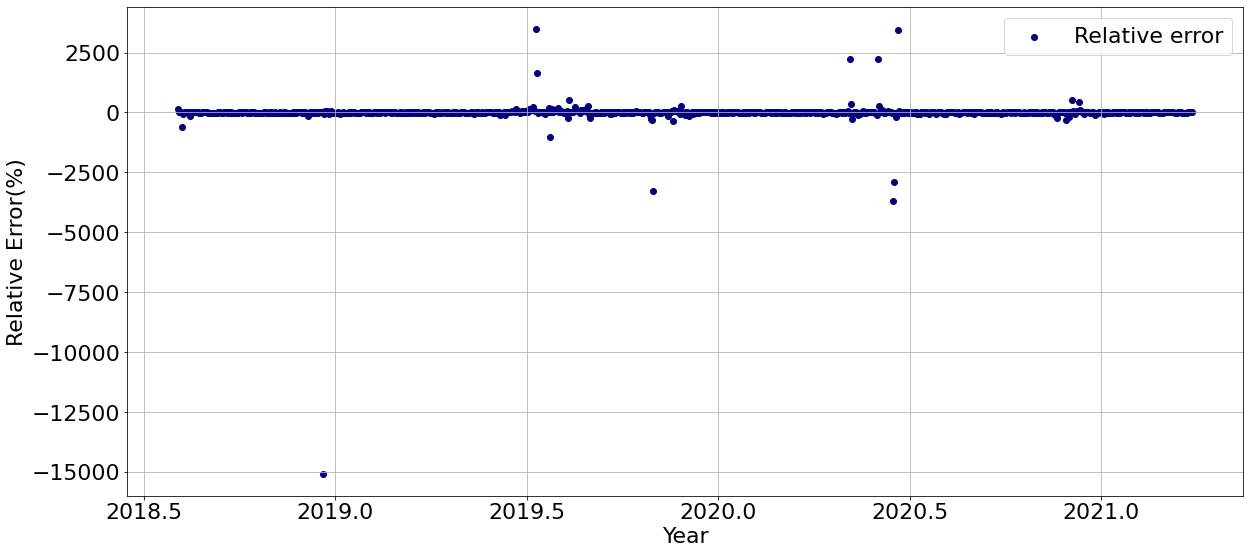

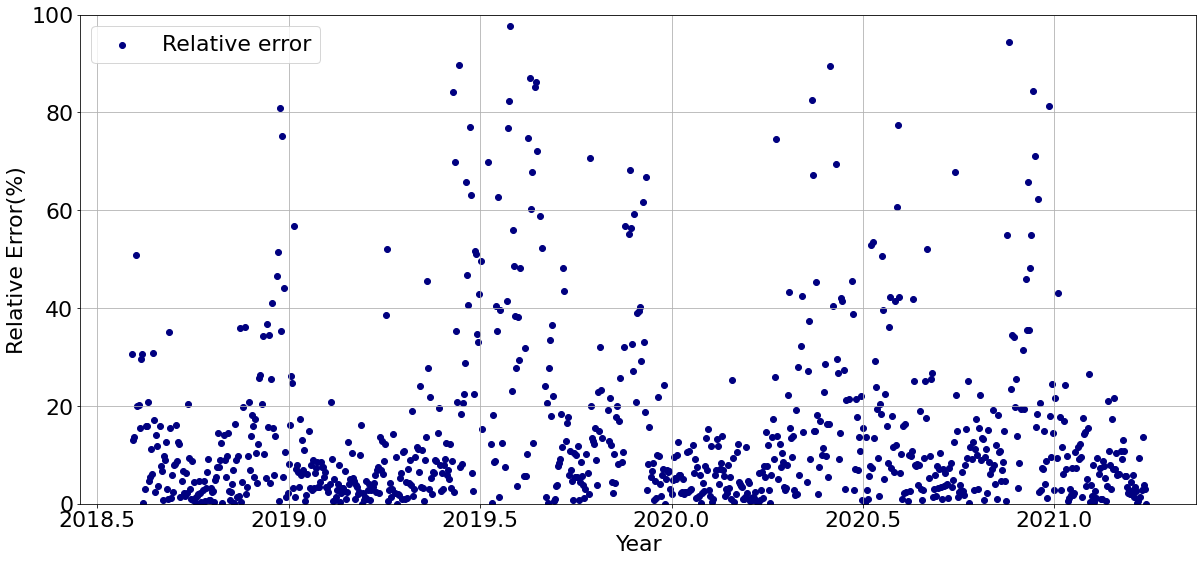

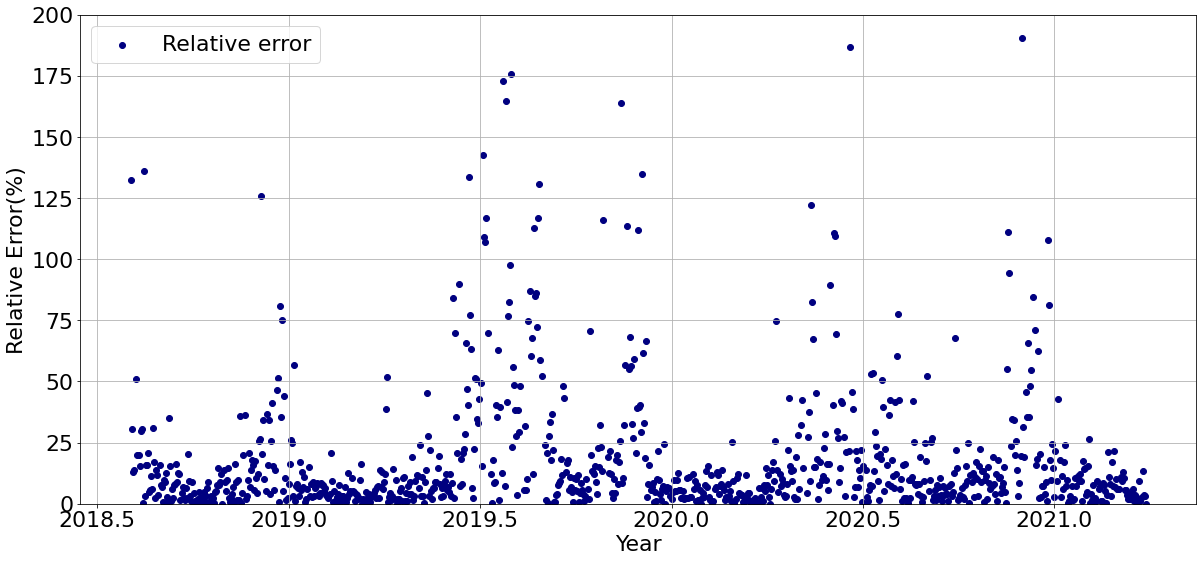

RMSE: 0.10366113387153594
MAE: 0.07805430054165623


In [26]:
plotting_predictions(number_of_years=16,filename="test",show_error=True);